In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

# Standard Imports
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import os
import glob
import seaborn as sns
import warnings
import datetime
warnings.simplefilter(action='ignore', category=FutureWarning)

# ESIO Imports

from esio import EsioData as ed
from esio import import_data
from esio import ice_plot

In [2]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
E = ed.EsioData.load()
# Directories
all_models=['szapirosipn']
runType='forecast'
updateall = False

In [4]:
stero_grid_file = E.obs['NSIDC_0051']['grid']
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [5]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

In [6]:
## TODO
# - Get mask
# - Get lat lon bounds 

In [7]:
var_dic = {'TLON':'lon','TLAT':'lat','hi_d':'hi','aice_d':'sic'}

In [8]:
prefix = 'MPAS'

In [9]:
for model in all_models:
    print('Regridding ', model, '...')
    
    weights_flag = False # Flag to set up weights have been created
    
    data_dir = os.path.join('/home/disk/sipn/upload/', model, runType)
    data_out = E.model[model][runType]['sipn_nc']
    model_grid_file = E.model[model]['grid']
    
    # Files are stored as /initmonth/ensemeble/runs/each valid time file .nc
    
    # First get number of initmonths
    initmonths = os.listdir(data_dir)
    
    # for each init month
    for c_it in initmonths:
        ds_all = []
        
        # for each ensemble
        ens = os.listdir(os.path.join(data_dir,c_it))
        for (e, c_en) in enumerate(ens):
            print(e)
            # Get files
            c_files = glob.glob(os.path.join(data_dir,c_it, c_en, '**','mp*.nc'), recursive=True)
            print("Found ",len(c_files), " files.")
            
            # Get init_date
            # mp25a.2018-05-31.005.gfs.cice.h1.2018-08-20.nc
            init_date = np.datetime64(os.path.basename(c_files[0]).split('.')[1])
            
            # open
            drop_vars = ['d2','nc','mkbio','nkice','nksnow']
            ds = xr.open_mfdataset(c_files, concat_dim='time', drop_variables=drop_vars, autoclose=True)
            # Rename variables per esipn guidelines
            ds.rename(var_dic, inplace=True);
            ds = ds[['sic','hi','tmask']]
            
            ds.rename({'time':'valid_time'}, inplace=True)
            ds.coords['init_time'] = init_date
            ds.coords['fore_time'] = ds.valid_time - ds.init_time
            ds.swap_dims({'valid_time':'fore_time'}, inplace=True)
            ds = ds.drop('valid_time')
            ds.coords['ensemble'] = e
            
            # Mask land out
            #ds = ds.where(ds.tmask==0)
            
            # Save
            ds_all.append(ds)
        ds_ens = xr.concat(ds_all, dim='ensemble')
            
        # Calculate regridding matrix
        regridder = xe.Regridder(ds_ens, obs_grid, method, periodic=True, reuse_weights=weights_flag)
        weights_flag = True # Set true for following loops

        # Add NaNs to empty rows of matrix (forces any target cell with ANY source cells containing NaN to be NaN)
        if method=='conservative':
            regridder = import_data.add_matrix_NaNs(regridder)

        # Regrid variables
        var_list = []
        for cvar in ds_ens.data_vars:
            var_list.append(regridder(ds_ens[cvar]))
        ds_out = xr.merge(var_list)

        # Expand dims
        ds_out = import_data.expand_to_sipn_dims(ds_out)

        # Save regridded to netcdf file
        f_out = os.path.join(data_out, prefix+'_'+pd.to_datetime(init_date).strftime('%Y-%m-%d')+'.nc')
        ds_out.to_netcdf(f_out)

        # Memory clean up
        ds_out = None 
#         ds = None
        ds_ens = None
        print('Saved ', f_out)

Regridding  szapirosipn ...
0
Found  124  files.
1
Found  124  files.
2
Found  122  files.
3
Found  123  files.


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


Create weight file: nearest_s2d_384x320_304x448_peri.nc
Saved  /home/disk/sipn/nicway/data/model/szapirosipn/forecast/sipn_nc/MPAS_2018-05-31.nc
0
Found  95  files.
1
Found  95  files.
2
Found  95  files.
3
Found  95  files.
4
Found  95  files.


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


Reuse existing file: nearest_s2d_384x320_304x448_peri.nc
Saved  /home/disk/sipn/nicway/data/model/szapirosipn/forecast/sipn_nc/MPAS_2018-06-30.nc
0
Found  30  files.
1
Found  30  files.
2
Found  30  files.
3
Found  30  files.


/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)


Reuse existing file: nearest_s2d_384x320_304x448_peri.nc
Saved  /home/disk/sipn/nicway/data/model/szapirosipn/forecast/sipn_nc/MPAS_2018-07-30.nc


In [10]:
# Clean up
if weights_flag:
    regridder.clean_weight_file()  # clean-up

Remove file nearest_s2d_384x320_304x448_peri.nc


# Plotting

Text(0.5,1,'Target Grid')

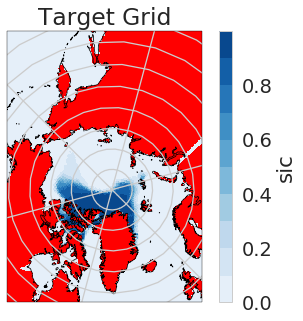

In [11]:
sic_all = xr.open_mfdataset(f_out)
sic_all

# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10))
cmap_sic.set_bad(color = 'red')

# # Plot original projection
# plt.figure(figsize=(20,10))
# ax1 = plt.axes(projection=ccrs.PlateCarree())
# ds_p = ds.sic.isel(fore_time=8)
# ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                  vmin=0, vmax=1,
#                                  cmap=matplotlib.colors.ListedColormap(sns.color_palette("Blues", 10)),
#                     transform=ccrs.PlateCarree());
# ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
# gl = ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
# gl.xlabels_bottom = True
# gl.ylabels_left = True
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# ax1.coastlines(linewidth=0.75, color='black', resolution='50m');

# # Plot SIC on target projection
# (f, ax1) = ice_plot.polar_axis()
# ds_p.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
#                                      transform=ccrs.PlateCarree(),
#                                      cmap=cmap_sic)
# ax1.set_title('Original Grid')

# Plot SIC on target projection
(f, ax1) = ice_plot.polar_axis()
ds_p2 = sic_all.sic.isel(init_time=0).isel(fore_time=8).isel(ensemble=3)
ds_p2.plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                     transform=ccrs.PlateCarree(),
                                     cmap=cmap_sic)
ax1.set_title('Target Grid')
